In [1]:
import warnings
import numpy as np
from hmmlearn import hmm
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
from googlefinance.client import get_price_data

# add a warning suppressing
warnings.filterwarnings("ignore")

<h1> Hidden Markov Models </h1><br>Application the GBPEUR Exchange rate overe the last five years
<br>
The data will be downloaded using a spreadsheet (<i>googlefinance client no longer works)  </i><br>
Note that the hmm is no longer part of sklearn (release 0.17). The command <i>pip install hmmlearn</i> is required.

In [2]:
df = pd.read_excel('EURGBP.xlsx',index_col='date')
df.head()

,EURGBP
date,
2007-10-23,0.69575
2007-10-24,0.69550
2007-10-25,0.69765
2007-10-26,0.70100
2007-10-29,0.69895


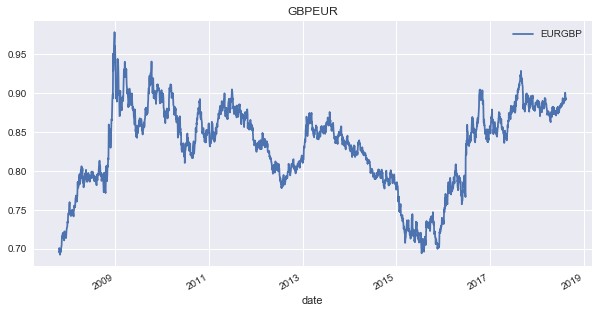

In [3]:
df.plot(figsize=(10,5),title='GBPEUR');

Calculating (log) returns for the dataset

In [4]:
df['Ret']= df['EURGBP'].pct_change(periods=1)
df['LogRet'] = df['Ret'].apply(lambda x: np.log(1+x))
df.dropna(how='any',inplace=True)

We opt for a hidden markov model with <b>3 hidden states </b>. Each state has a <b> Gaussian Emission </b> to visible states. The visible states are the sequence of daily logreturns observed for the GBPEUR Exchange Rate.

In [5]:
X = df['LogRet'].values.reshape(-1,1)
model = hmm.GaussianHMM(n_components=3, covariance_type="full")
model.fit(X)

GaussianHMM(algorithm='viterbi', covariance_type='full', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=3, n_iter=10, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)

Fitting the model to the data will reveal information on :
<ol>
<li> The transition matrix "orchestrating" the way that the hidden states move between each other. 
<li> The Emission from each of the hidden states to the visible states takes Gaussian model (mean + variance)
</ol>

In [6]:
model.transmat_

array([[0.24837489, 0.37056596, 0.38105915],
       [0.19247788, 0.39781937, 0.40970275],
       [0.1923061 , 0.39787678, 0.40981712]])

In [7]:
print('transition matrix')
pd.DataFrame(model.transmat_)

transition matrix


,0,1,2
0,0.248375,0.370566,0.381059
1,0.192478,0.397819,0.409703
2,0.192306,0.397877,0.409817


<b> Is there a stationary state ? </b>

In [40]:
P = np.array(model.transmat_)
P.shape
np.dot(np.dot(np.dot(np.dot(P,P),P),P),P)

array([[0.2037943 , 0.40387011, 0.39233559],
       [0.20379375, 0.40387039, 0.39233586],
       [0.20379375, 0.40387039, 0.39233586]])

In [10]:
model.means_.ravel()

array([ 5.36709092e-04, -3.21208977e-05, -1.90613137e-05])

In [11]:
print('Means of the Gaussians')
print(model.means_.ravel())
print('Hidden State 0 is producing random normal numbers with mean ',np.round(np.float(model.means_[0]),8))

Means of the Gaussians
[ 5.36709092e-04 -3.21208977e-05 -1.90613137e-05]
Hidden State 0 is producing random normal numbers with mean  0.00053671


In [12]:
print('Standard deviations')
print(np.sqrt(model.covars_.ravel())*100*np.sqrt(250))

Standard deviations
[14.96267542  8.9922739   8.90177113]


The first two states generate returns with a very similar standard deviation and it makes sense to group these together.
Both hidden states have also positive returns. <br>
<b>=>Opting for 2 hidden states</b>

In [13]:
model = hmm.GaussianHMM(n_components=2, covariance_type="full")
model.fit(X)

GaussianHMM(algorithm='viterbi', covariance_type='full', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=2, n_iter=10, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)

In [14]:
print('transition matrix')
print(pd.DataFrame(model.transmat_))
print('\nWhat do these data tell you ?\nWhat is the most frequent state?')

transition matrix
          0         1
0  0.407506  0.592494
1  0.362483  0.637517

What do these data tell you ?
What is the most frequent state?


In [15]:
print('Means of the Gaussians')
print(model.means_.ravel())

Means of the Gaussians
[ 2.7546811e-04 -2.4953595e-05]


In [16]:
print('Standard deviations')
print(np.sqrt(model.covars_.ravel())*100)

Standard deviations
[0.80062707 0.50580043]


From the sequence $X$ (= observed log returns), one can derive the corresponding hidden states. This done using the <b>Viterbi</b> algortihm

In [17]:
Z = model.predict(X).reshape(-1,1)

In [28]:
T = model.transmat_
np.dot(np.dot(np.dot(np.dot(T,T),T),T),T)

array([[0.37957299, 0.62042701],
       [0.37957281, 0.62042719]])

In [27]:
np.sum(df_result==1)/len(df_result)

0    0.908994
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1b728518>]],
      dtype=object)

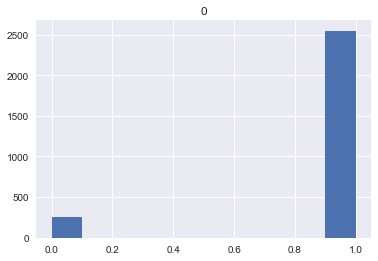

In [25]:
df_result=pd.DataFrame(Z)
df_result.hist()

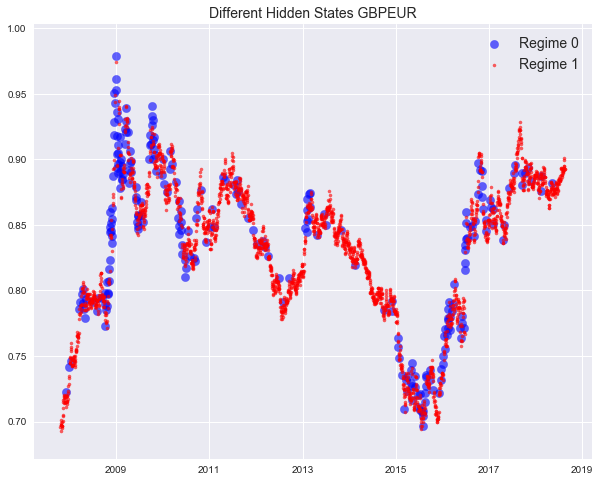

In [30]:
fig = plt.subplots(1,1,figsize=(10,8))
color = ['b','r']
size = [70,10]
for z , c , s , i in zip(np.unique(Z),
                         color,size,
                         np.arange(0,len(model.means_))):
    idx = Z ==z
    plt.scatter(df[Z==z].index,
                df[Z==z]['EURGBP'],
                c=c,
                s=s,
                alpha=0.6,
               label='Regime '+str(i))
plt.title('Different Hidden States GBPEUR',fontsize=14);
plt.legend(loc=1,fontsize=14);

Can we plot the evolution of the "High Volatility Regime" post / pre Brexit ?
<br>In a rolling window of 250 days, we can count the number of high volatility days<br>

In [33]:
df.head()

,EURGBP,Ret,LogRet,Regime,HighVolDays
date,,,,,
2007-10-24,0.69550,-0.000359,-0.000359,1,NaN
2007-10-25,0.69765,0.003091,0.003087,1,NaN
2007-10-26,0.70100,0.004802,0.004790,1,NaN
2007-10-29,0.69895,-0.002924,-0.002929,1,NaN
2007-10-30,0.69720,-0.002504,-0.002507,1,NaN


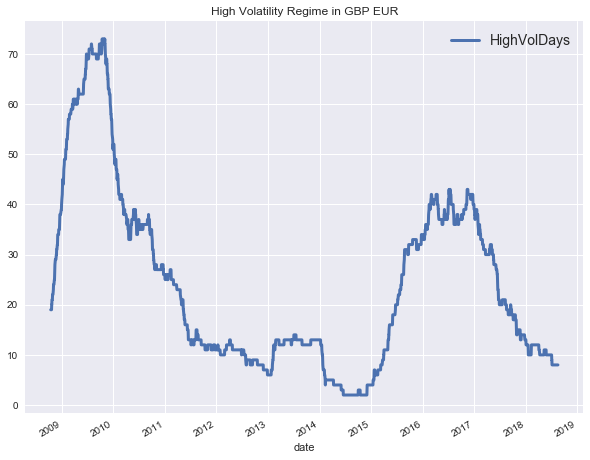

In [44]:
df['Regime']= Z
df['HighVolDays']=df['Regime'].rolling(window=250).apply(lambda x : np.sum(x==0))
df['HighVolDays'].plot(figsize=(10,8),title='High Volatility Regime in GBP EUR',linewidth=3);
df['Vol']=df['LogRet'].rolling(window=250).apply(lambda x : np.std(x)*np.sqrt(250)*100)
plt.legend(fontsize=14);

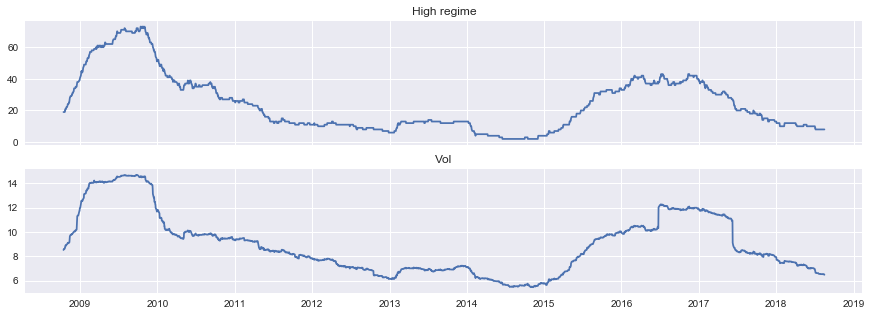

In [45]:
fig,ax = plt.subplots(2,1,sharex=True,figsize=(15,5))
ax[0].plot(df.index,df['HighVolDays'])
ax[0].set_title('High regime')
ax[1].plot(df.index,df['Vol'])
ax[1].set_title('Vol');